In [1]:
%cd ../..

/home/rasmusj/code


In [2]:
import sys
import random

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.train
from tensorflow.keras import layers
from gconvnet import GConv2D

In [3]:
print('Tensorflow version: {}'.format(tf.__version__))
print('Keras      version: {}'.format(tf.keras.__version__))
print('Numpy version:      {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Python version:     {}'.format(sys.version))

Tensorflow version: 1.14.0
Keras      version: 2.2.4-tf
Numpy version:      1.16.4
Matplotlib version: 3.1.0
Python version:     3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


We now load the MNIST data. It is organized as follows:
* Each samples is represented as 785 scalars. The first 24*24=784 are the pixel values. The last is the label.
* mnist_train.amat contains 12,000 samples. The first 10,000 are training samples, the last 2000 are validation samples.
* mnist_test.amat contains 50,000 test samples.

In [4]:
train_n = 10000 
val_n = 2000
test_n = 50000
sample_width = 28
sample_height = 28

In [5]:
raw_train_val_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_train_valid.amat')
raw_test_data = np.loadtxt('gconvnet/examples/mnist_all_rotation_normalized_float_test.amat')

In [6]:
assert raw_train_val_data.shape[0] == train_n + val_n, \
       'mnist_train.amat had unexpected number of samples'
assert raw_test_data.shape[0] == test_n, \
       'mnist_test.amat had unexpected number of samples'

assert raw_train_val_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_train.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_train_val_data.shape[1])
assert raw_test_data.shape[1] == sample_width*sample_height + 1, \
    "mnist_test.amat samples have wrong size, expected {0} got {1}".format(
           sample_width*sample_height+1, raw_test_data.shape[1])

train_x = raw_train_val_data[:train_n,:-1].reshape(train_n,sample_width,sample_height,1,1)
train_y = raw_train_val_data[:train_n,-1]

val_x = raw_train_val_data[train_n:,:-1].reshape(val_n,sample_width,sample_height,1,1)
val_y = raw_train_val_data[train_n:,-1]

test_x = raw_test_data[:,:-1].reshape(test_n,sample_width,sample_height,1,1)
test_y = raw_test_data[:,-1]

train_data = {
    'x' : train_x,
    'y' : train_y,
    'y_cat' : tf.keras.utils.to_categorical(train_y,10),
    'name' : 'train',
    'n' : train_n}
test_data = {
    'x' : test_x,
    'y' : test_y,
    'y_cat' : tf.keras.utils.to_categorical(test_y,10),
    'name' : 'test',
    'n' : test_n}
val_data = {
    'x' : val_x,
    'y' : val_y,
    'y_cat' : tf.keras.utils.to_categorical(val_y,10),
    'name' : 'validation',
    'n' : val_n}

# Inspection

Train dataset sample #6611 with label: 3.0


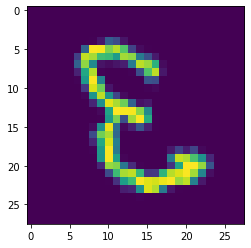

In [7]:
dataset_to_inspect = train_data
example_idx = -1 # index of sample to inspect. -1 for random.

if example_idx == -1:
    example_idx = random.randint(0,dataset_to_inspect['n']-1)

assert (example_idx >= 0 and example_idx < dataset_to_inspect['n']-1), \
    'Example index out of bounds'

example_x = dataset_to_inspect['x'][example_idx].reshape(sample_width,sample_height)
example_y = dataset_to_inspect['y'][example_idx]

plt.imshow(example_x)

print('{0} dataset sample #{1} with label: {2}'.format(
    dataset_to_inspect['name'].capitalize(), example_idx, example_y))

# Model

In [32]:
custommodel = keras.Sequential()
custommodel.add(GConv2D(30, 
                        kernel_size=(3,3),
                        input_shape=(28,28,1,1),
                        G = 'c4',
                        G_action = 'rot90',
                        activation='relu',
                        use_bias = False,
                        name='GConv1'))
custommodel.add(GConv2D(30,
                       kernel_size=(3,3),
                       G='c4',
                       G_action = 'rot90',
                       activation='relu',
                       use_bias=False,
                       name='GConv2'))
custommodel.add(GConv2D(30,
                       kernel_size=(3,3),
                       G='c4',
                       G_action = 'rot90',
                       activation='relu',
                       use_bias=False,
                       name='GConv3'))
custommodel.add(GConv2D(30,
                       kernel_size=(3,3),
                       G='c4',
                       G_action = 'rot90',
                       activation='relu',
                       use_bias=False,
                       name='GConv4'))
custommodel.add(layers.Flatten())
custommodel.add(layers.Dense(10, activation='softmax'))

-1 1 1
-1 1 1
Applying GConv1
Input shape: (?, 28, 28, 1, 1)
Filtershape: (3, 3, 1, 1, 4, 30)
Output shape: (?, 26, 26, 120)
Output shape: (?, 26, 26, 4, 30)
-1 1 1
-1 1 1
Applying GConv2
Input shape: (?, 26, 26, 4, 30)
Filtershape: (3, 3, 4, 30, 4, 30)
Output shape: (?, 24, 24, 120)
Output shape: (?, 24, 24, 4, 30)
-1 1 1
-1 1 1
Applying GConv3
Input shape: (?, 24, 24, 4, 30)
Filtershape: (3, 3, 4, 30, 4, 30)
Output shape: (?, 22, 22, 120)
Output shape: (?, 22, 22, 4, 30)
-1 1 1
-1 1 1
Applying GConv4
Input shape: (?, 22, 22, 4, 30)
Filtershape: (3, 3, 4, 30, 4, 30)
Output shape: (?, 20, 20, 120)
Output shape: (?, 20, 20, 4, 30)


In [9]:
custommodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GConv1 (GConv2D)             (None, 26, 26, 4, 30)     270       
_________________________________________________________________
flatten (Flatten)            (None, 81120)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                811210    
Total params: 811,480
Trainable params: 811,480
Non-trainable params: 0
_________________________________________________________________


In [33]:
custommodel.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [34]:
custommodel.fit(
    train_data['x'],
    train_data['y_cat'],
    batch_size=128,
    epochs=10)

Epoch 1/25
10000/10000 [==============================] - 4s 436us/sample - loss: 1.0854 - acc: 0.6339
Epoch 2/25
10000/10000 [==============================] - 4s 387us/sample - loss: 0.4753 - acc: 0.8522
Epoch 3/25
10000/10000 [==============================] - 4s 390us/sample - loss: 0.2843 - acc: 0.9097
Epoch 4/25
10000/10000 [==============================] - 4s 390us/sample - loss: 0.1596 - acc: 0.9483
Epoch 5/25
10000/10000 [==============================] - 4s 390us/sample - loss: 0.0869 - acc: 0.9687
Epoch 6/25
10000/10000 [==============================] - 4s 390us/sample - loss: 0.0599 - acc: 0.9789
Epoch 7/25
10000/10000 [==============================] - 4s 391us/sample - loss: 0.0275 - acc: 0.9906
Epoch 8/25
10000/10000 [==============================] - 4s 392us/sample - loss: 0.0359 - acc: 0.9868
Epoch 9/25
10000/10000 [==============================] - 4s 405us/sample - loss: 0.0250 - acc: 0.9906
Epoch 10/25
10000/10000 [==============================] - 4s 401us/sampl

In [35]:
custommodel.evaluate(val_data['x'],val_data['y_cat'])

2000/2000 [==============================] - 1s 253us/sample - loss: 0.8521 - acc: 0.8930


[0.8521332949176431, 0.893]